In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [10]:
# Load the dataset
file_path = './symbipredict_2022.csv'
dataset = pd.read_csv(file_path)

In [11]:
# Display dataset information
print("Dataset Head:")
print(dataset.head())
print("\nDataset Info:")
print(dataset.info())
print("\nMissing Values:")
print(dataset.isnull().sum())

Dataset Head:
   itching  skin_rash  nodal_skin_eruptions  continuous_sneezing  shivering  \
0        1          1                     1                    0          0   
1        0          1                     1                    0          0   
2        1          0                     1                    0          0   
3        1          1                     0                    0          0   
4        1          1                     1                    0          0   

   chills  joint_pain  stomach_pain  acidity  ulcers_on_tongue  ...  \
0       0           0             0        0                 0  ...   
1       0           0             0        0                 0  ...   
2       0           0             0        0                 0  ...   
3       0           0             0        0                 0  ...   
4       0           0             0        0                 0  ...   

   blackheads  scurring  skin_peeling  silver_like_dusting  \
0           0         

In [12]:
# Drop rows with missing values (if any)
dataset.dropna(inplace=True)

In [13]:

# Features and target separation
X = dataset.drop(columns=['prognosis'])
y = dataset['prognosis']

In [14]:
# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
joblib.dump(label_encoder, 'label_encoder.pkl')

['label_encoder.pkl']

In [15]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

In [16]:
print(f'Training Features Shape: {X_train.shape}')
print(f'Testing Features Shape: {X_test.shape}')
print(f'Training Labels Shape: {y_train.shape}')
print(f'Testing Labels Shape: {y_test.shape}')

# Initialize and train the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

Training Features Shape: (3968, 132)
Testing Features Shape: (993, 132)
Training Labels Shape: (3968,)
Testing Labels Shape: (993,)


RandomForestClassifier(random_state=42)

In [17]:
# Make predictions
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'\nModel Accuracy: {accuracy:.2f}')

class_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print("\nClassification Report:")
print(class_report)


Model Accuracy: 1.00

Classification Report:
                               precision    recall  f1-score   support

                         AIDS       1.00      1.00      1.00        24
                         Acne       1.00      1.00      1.00        24
          Alcoholic Hepatitis       1.00      1.00      1.00        24
                      Allergy       1.00      1.00      1.00        24
                    Arthritis       1.00      1.00      1.00        24
             Bronchial Asthma       1.00      1.00      1.00        24
         Cervical Spondylosis       1.00      1.00      1.00        24
                   Chickenpox       1.00      1.00      1.00        25
          Chronic Cholestasis       1.00      1.00      1.00        24
                  Common Cold       1.00      1.00      1.00        24
                       Dengue       1.00      1.00      1.00        25
                    Diabetes        1.00      1.00      1.00        24
Dimorphic Hemmorhoids (piles) 

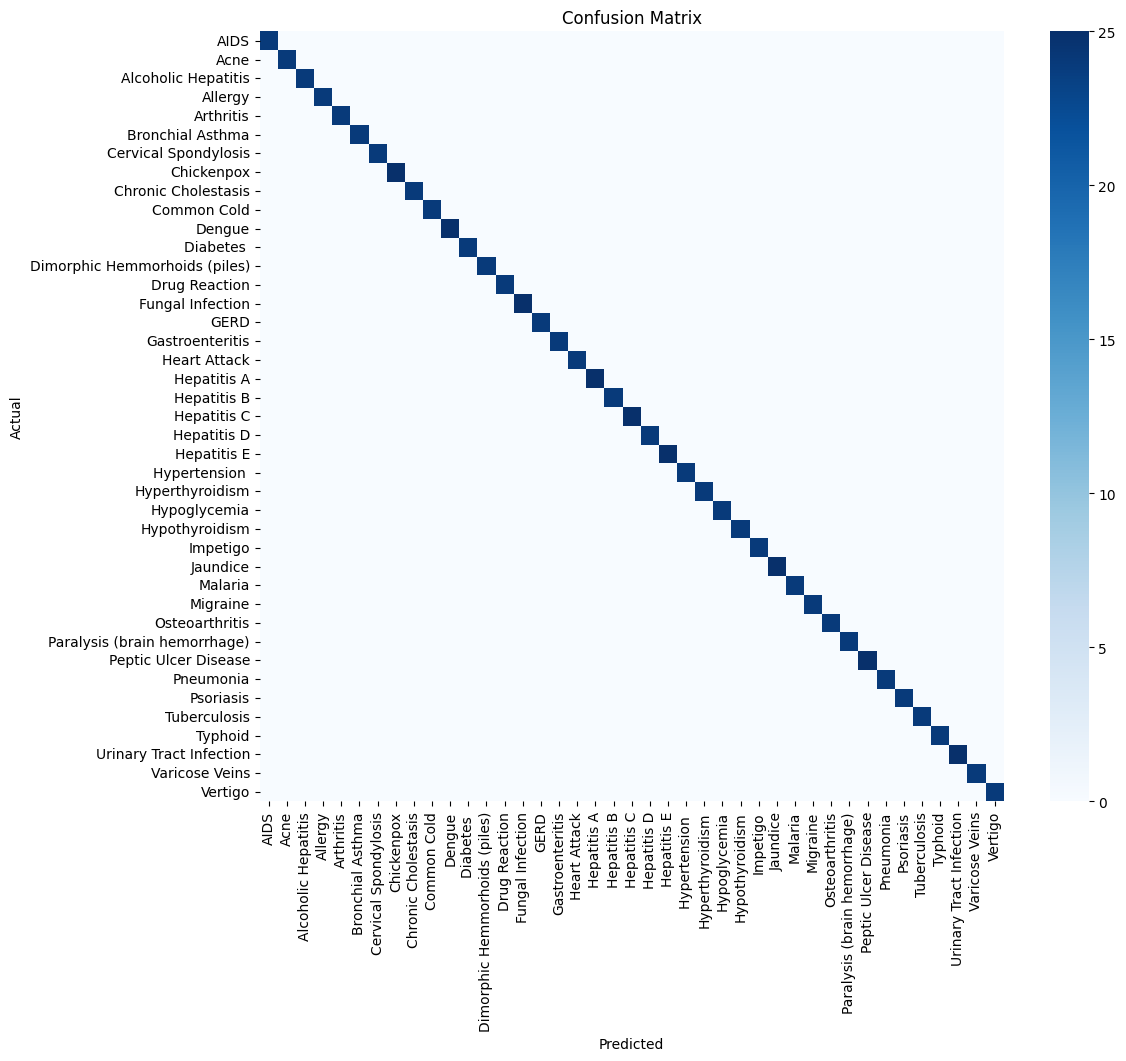

In [18]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=False, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Feature Importance
importances = rf_classifier.feature_importances_
feature_names = X.columns

feature_importances = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

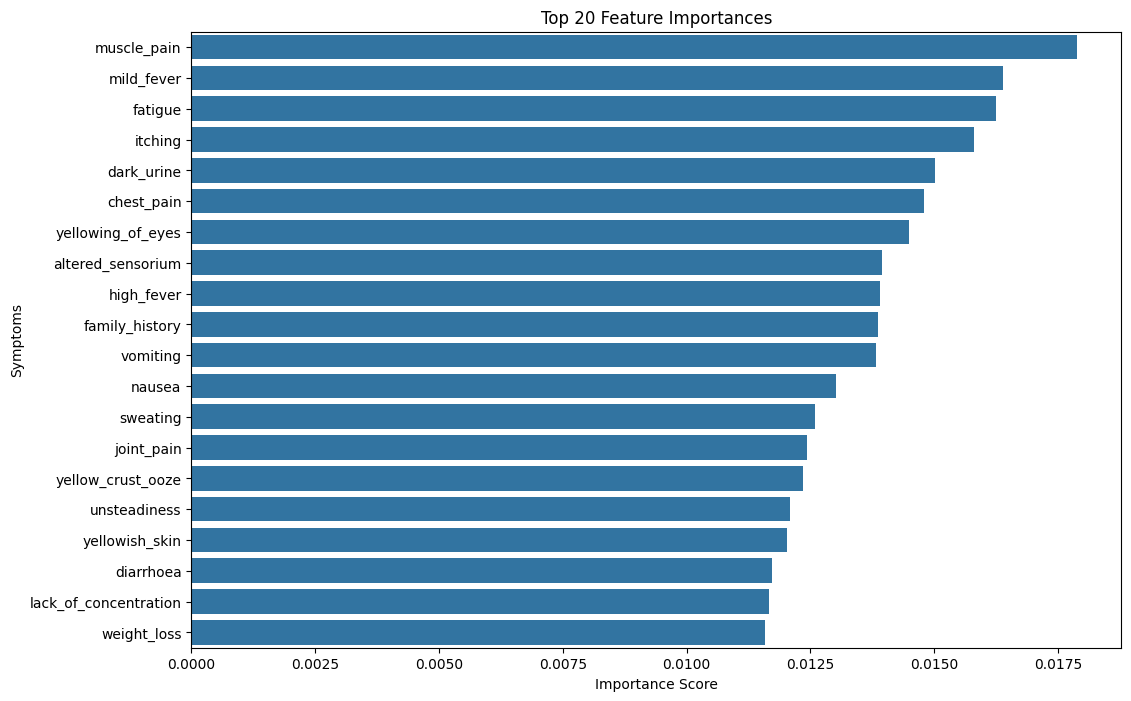


Cross-Validation Scores: [1. 1. 1. 1. 1.]
Average CV Accuracy: 1.00


In [19]:
feature_importances.sort_values(by='importance', ascending=False, inplace=True)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importances.head(20))
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Symptoms')
plt.show()

# (Optional) Cross-Validation
cv_scores = cross_val_score(rf_classifier, X_train, y_train, cv=5, scoring='accuracy')
print(f'\nCross-Validation Scores: {cv_scores}')
print(f'Average CV Accuracy: {cv_scores.mean():.2f}')

In [20]:
# Save the trained model
joblib.dump(rf_classifier, 'disease_predictor_model.pkl')
print("\nModel and Label Encoder have been saved successfully!")


Model and Label Encoder have been saved successfully!


In [45]:
import pandas as pd
import joblib

def predict_disease(symptoms):
    """
    Predicts the disease based on symptoms provided as a DataFrame, then retrieves the suitable doctor for the disease.
    
    Parameters:
        symptoms (pd.DataFrame): A DataFrame with symptom names as columns.
    
    Returns:
        tuple: Predicted disease and the suitable doctor.
    """
    # Load the model and label encoder
    rf_model = joblib.load('./disease_predictor_model.pkl')
    label_encoder = joblib.load('./label_encoder.pkl')
    
    # Load the training feature names (columns used during model training)
    feature_names = rf_model.feature_names_in_
    
    # Align the input DataFrame with the model's feature names, filling missing features with 0
    symptoms_aligned = symptoms.reindex(columns=feature_names, fill_value=0)
    
    # Make prediction
    prediction = rf_model.predict(symptoms_aligned)
    predicted_disease = label_encoder.inverse_transform(prediction)[0]
    
    # Load the CSV file with diseases and doctors
    doctor_data = pd.read_csv('./diseases_and_doctors.csv')
    
    # Find the suitable doctor for the predicted disease, ignoring case
    doctor_row = doctor_data[doctor_data['Disease'].str.lower() == predicted_disease.lower()]
    if not doctor_row.empty:
        suitable_doctor = doctor_row['Suitable_Doctor'].values[0]
    else:
        suitable_doctor = "No suitable doctor found"
    
    return predicted_disease, suitable_doctor

# Example usage with new symptoms data
example_data = pd.DataFrame([{
    'itching': 1,
    'skin_rash': 1,
    'nodal_skin_eruptions': 1,
    'Fatigue': 0,
    'Muscle Pain': 0,
    'Loss of Smell': 1,
    'Shortness of Breath': 0,
    # Only provide symptoms relevant to this prediction. The rest will be filled with 0.
}])

predicted_disease, suitable_doctor = predict_disease(example_data)
print(f'Predicted Disease: {predicted_disease}')
print(f'Suitable Doctor: {suitable_doctor}')


Predicted Disease: Fungal Infection
Suitable Doctor: Dermatologist
